# Reporte analítica de datos - Proyecto de Grado II

## Modelamiento de los datos para el municipio de BUGA

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot
from pandas import DataFrame
from pandas import concat
from pandas.plotting import lag_plot
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
import datetime as datetime
import math
import warnings
import scipy

In [5]:
buga_1 = pd.read_csv('../../dengue_data/Buga.csv')
df1 = pd.DataFrame(buga_1)
bugadata_2 = pd.read_csv('../../dengue_data/Buga2019.csv')
bugadata_2 = bugadata_2[bugadata_2.Ano == 2019]
df2 = pd.DataFrame(bugadata_2)

buga_data = pd.concat([df1, df2], ignore_index=True)
buga_data["FecNot"]=pd.to_datetime(buga_data['FecNot'])
buga_data = buga_data.drop(columns='Id')

buga_data

,MesOcurrencia,FecNot,Semana,Ano,Edad,GrupoEdad,Sexo,Barrio,Comuna
0,enero,2010-01-14,1,2010,23,15 - 44,F,LA MERCED,4
1,enero,2010-11-01,1,2010,23,15 - 44,F,EL CARMELO,6
2,enero,2010-10-01,1,2010,20,15 - 44,M,EL CARMELO,6
3,enero,2010-12-01,1,2010,6,5 - 14,F,SUCRE,3
4,enero,2010-07-01,1,2010,13,5 - 14,M,POPULAR,5
...,...,...,...,...,...,...,...,...,...
3534,octubre,2019-09-11,44,2019,12,5 - 14,M,JOSE MARIA CABAL,4
3535,octubre,2019-10-23,42,2019,10,5 - 14,F,AURES,4
3536,diciembre,2019-11-12,49,2019,28,15 - 44,F,LA HONDA,5
3537,septiembre,2019-05-10,40,2019,76,> 60,M,SUCRE,3


In [6]:
def assign_zeros(nb_df) :
    day_delta = datetime.timedelta(days=1)
    start_date = datetime.date(2010, 1, 1)
    end_date = datetime.date(2020, 1, 1)

    list = []

    for i in range((end_date - start_date).days):
        date = start_date + i*day_delta
        try: 
            list.append(nb_df.at[date,'Casos'])
        except:  
            list.append(0)
            
    final_model = pd.DataFrame(columns=('Fecha', 'Casos'))

    for i in range((end_date - start_date).days):
        date = start_date + i*day_delta
        final_model.loc[len(final_model)]=[date, list[i]]
        
    return final_model

## MODELAMIENTO

### Predicciones de modelo AR

In [20]:
def AR_model(df_zeros, nb_name) :

    df_zeros['Values_shifted'] = df_zeros['Casos'].shift()

    fecha_1 = datetime.date(2016, 12, 31)
    fecha_2 = datetime.date(2017, 1, 1)

    df_train = df_zeros.loc[: fecha_1]
    df_test = df_zeros.loc[fecha_2: ]

    df_train = df_train.rename_axis('Fecha').reset_index()
    df_test = df_test.rename_axis('Fecha').reset_index()

    df_train.drop('Fecha', axis=1, inplace=True)
    df_train.dropna(inplace=True)
    df_test.drop('Fecha', axis=1, inplace=True)
    df_test.dropna(inplace=True)

    y1 = df_train.Casos.values
    X1 = df_train.Values_shifted.values

    y2 = df_test.Casos.values
    X2 = df_test.Values_shifted.values

    # Entrenamiento del modelo
    X_train, X_test = X1, X2
    y_train, y_test = y1, y2

    X_train = X_train.reshape(-1,1)
    X_test = X_test.reshape(-1,1)

    lr = LinearRegression()
    lr.fit(X_train, y_train)
    lr.coef_
    lr.intercept_
    y_pred = lr.predict(X_test)

    # Mostrar el modelo
    plt.plot(y_test[-1095:], label="Actual Values")
    plt.plot(y_pred[-1095:], label="Predicted Values")
    plt.legend()
    plt.title(nb_name)  
    plt.ylabel("Número de casos")  
    plt.show()

    # Análisis del modelo
    model = ARIMA(y_train, order=(1,0,0))
    model = model.fit()
    print(model.summary())

**PA LAS PRUEBAS**

In [25]:
nb_df = buga_data[buga_data.Barrio == "SANTA BARBARA"]
nb_df = pd.DataFrame(nb_df['FecNot'].value_counts().sort_index())
nb_df.columns = ['Casos']
nb_df.index.name = 'Fecha'
df_zeros = assign_zeros(nb_df)
df_zeros.set_index('Fecha',inplace=True)


In [26]:
df_zeros.head()

,Casos
Fecha,
2010-01-01,0
2010-01-02,0
2010-01-03,0
2010-01-04,0
2010-01-05,0


In [41]:
df_zeros['EMA'] = df_zeros.iloc[:,0].ewm(span=4,adjust=False).mean()
df_zeros.head()

,Casos,EMA
Fecha,,
2010-01-01,0,0.0
2010-01-02,0,0.0
2010-01-03,0,0.0
2010-01-04,0,0.0
2010-01-05,0,0.0


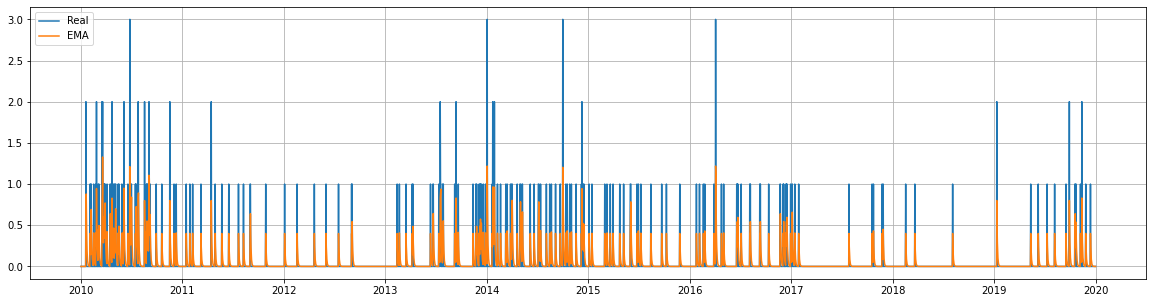

In [46]:
plt.figure(figsize=[20,5])
plt.grid(True)
plt.plot(df_zeros['Casos'],label='Real')
plt.plot(df_zeros['EMA'],label='EMA')
plt.legend(loc=2)

In [23]:
def AR_model2(series, nb_name) :

    fecha_1 = datetime.date(2016, 12, 31)
    fecha_2 = datetime.date(2017, 1, 1)

    df_train = series.loc[: fecha_1]
    df_test = series.loc[fecha_2: ]

    y1 = df_train.values

    y2 = df_test.values

    # Entrenamiento del modelo
    train, test = y1, y2

    # train autoregression
    window = 1000
    model = AutoReg(train, lags=1000)
    model_fit = model.fit()
    coef = model_fit.params
    
    # walk forward over time steps in test
    history = train[len(train)-window:]
    history = [history[i] for i in range(len(history))]
    predictions = list()
    for t in range(len(test)):
        length = len(history)
        lag = [history[i] for i in range(length-window,length)]
        yhat = coef[0]
        for d in range(window):
            yhat += coef[d+1] * lag[window-d-1]
        obs = test[t]
        predictions.append(abs(np.round(float(yhat))))
        history.append(obs)
    rmse = np.sqrt(mean_squared_error(test, predictions))
    print('Test RMSE: %.3f' % rmse)
    # plot
    pyplot.figure(figsize=(25,5))
    pyplot.plot(test)
    pyplot.plot(predictions, color='red')
    pyplot.title(nb_name)  
    pyplot.ylabel("Número de casos") 
    pyplot.xlabel("Días a predecir") 
    pyplot.show()

Test RMSE: 0.179


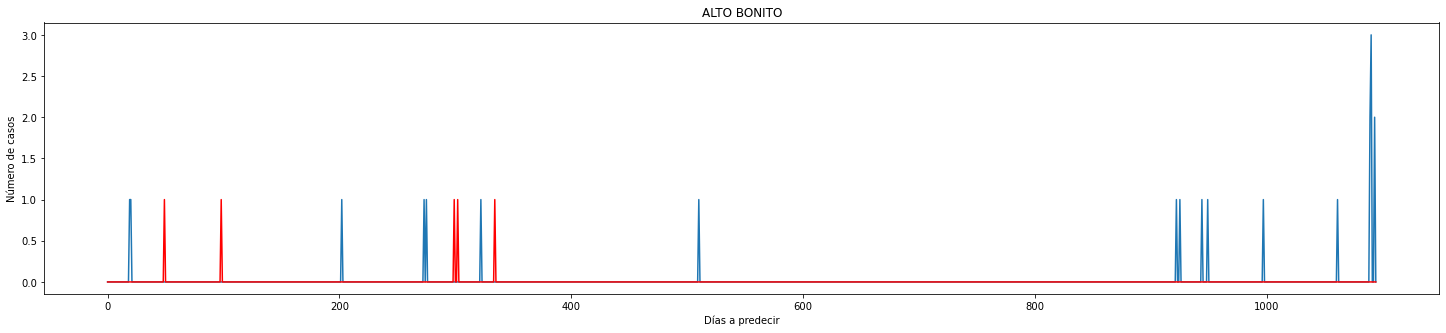

Test RMSE: 0.174


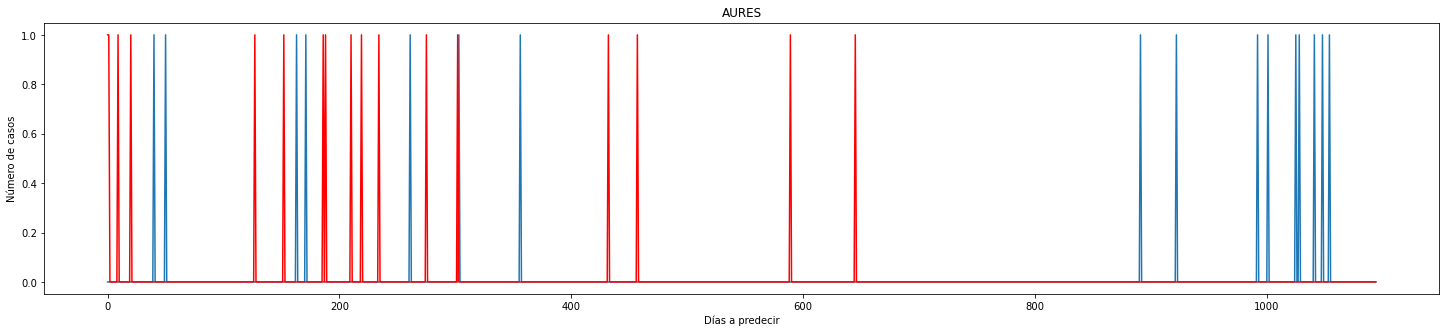

Test RMSE: 0.291


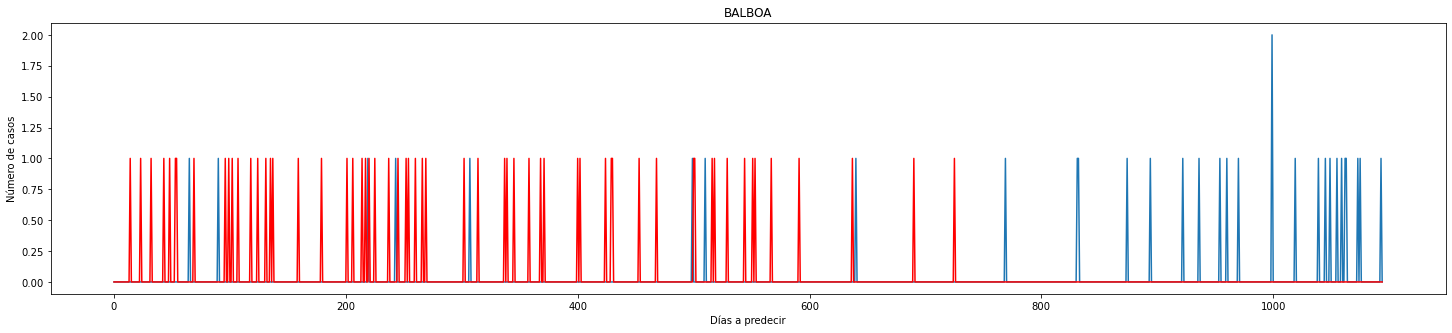

Test RMSE: 0.253


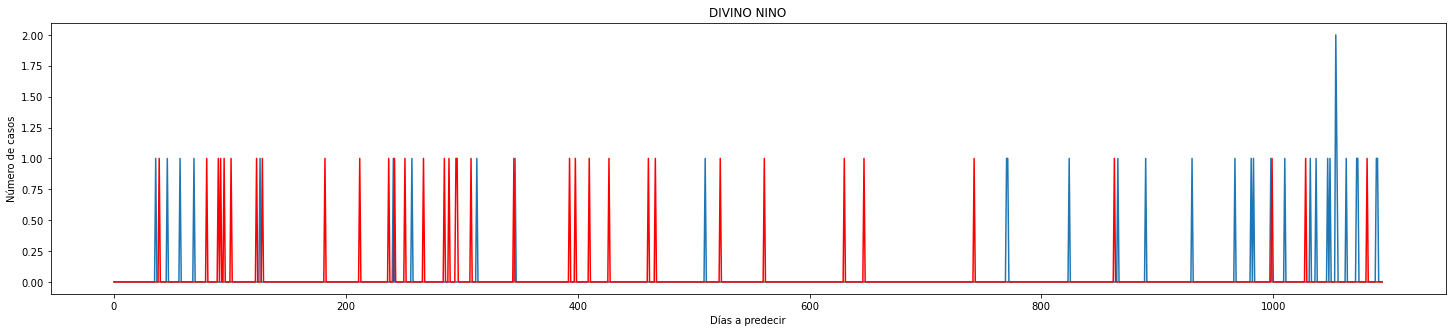

Test RMSE: 0.238


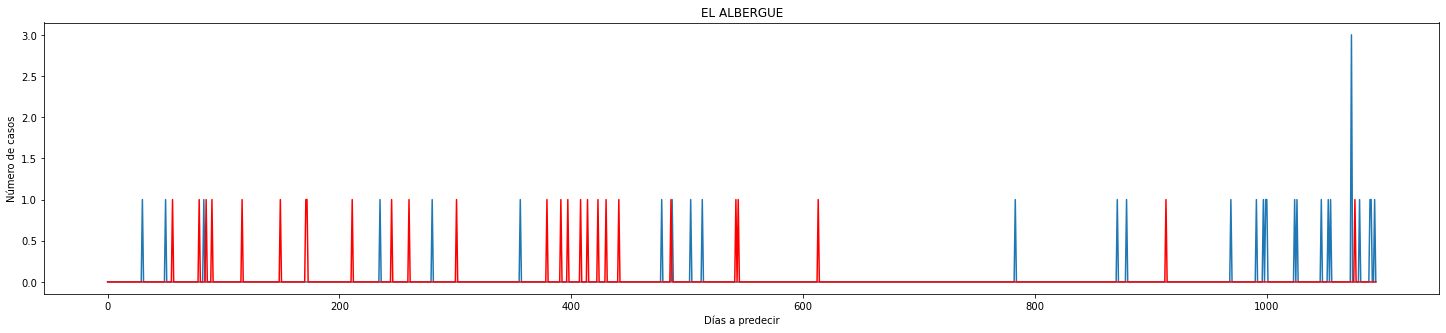

Test RMSE: 0.194


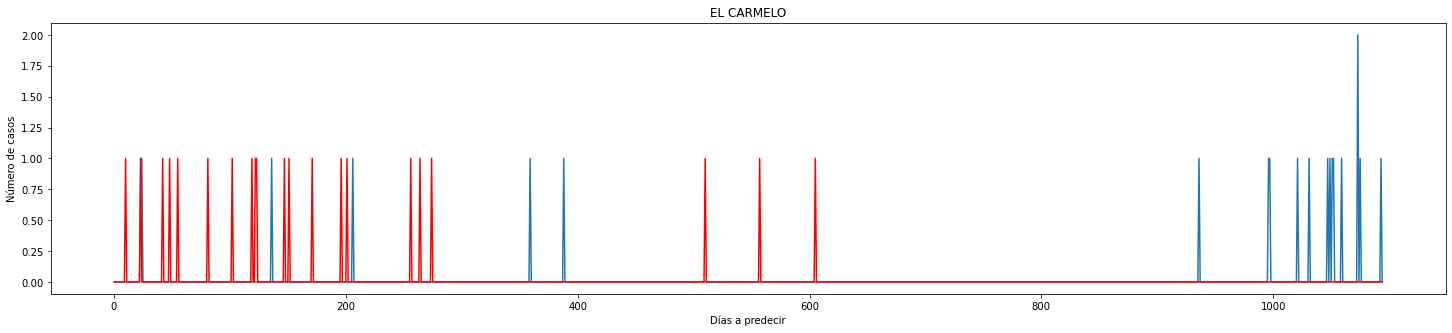

Test RMSE: 0.176


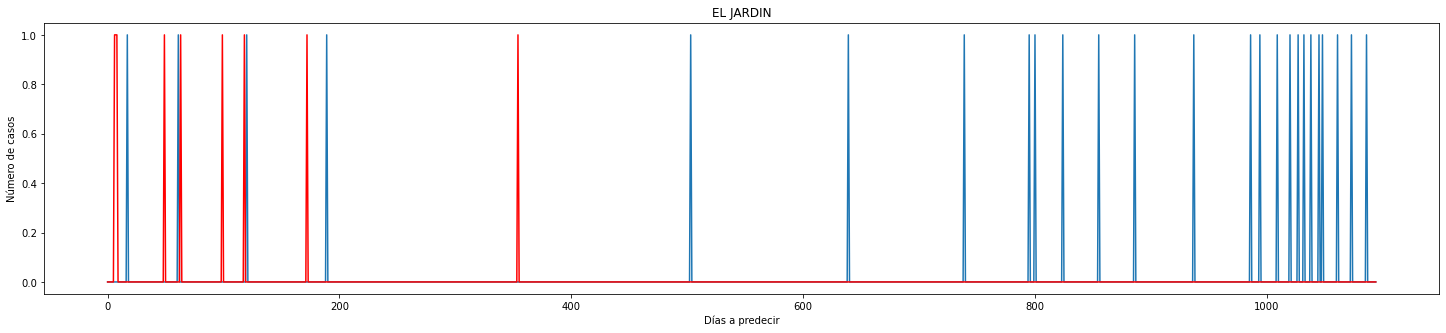

Test RMSE: 0.232


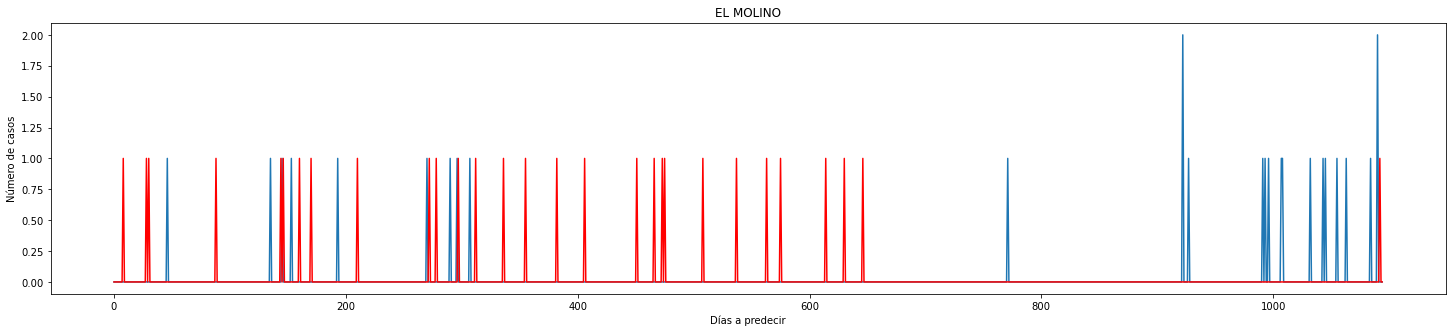

Test RMSE: 0.060


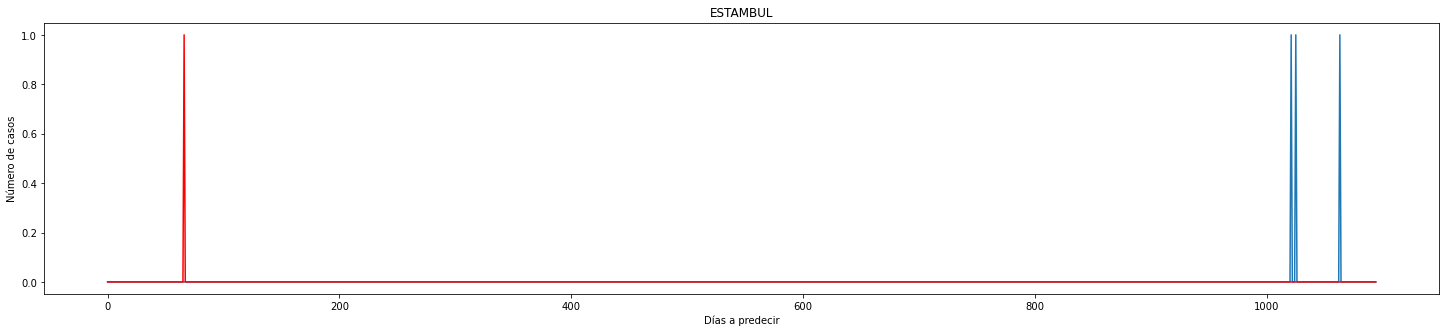

Test RMSE: 0.293


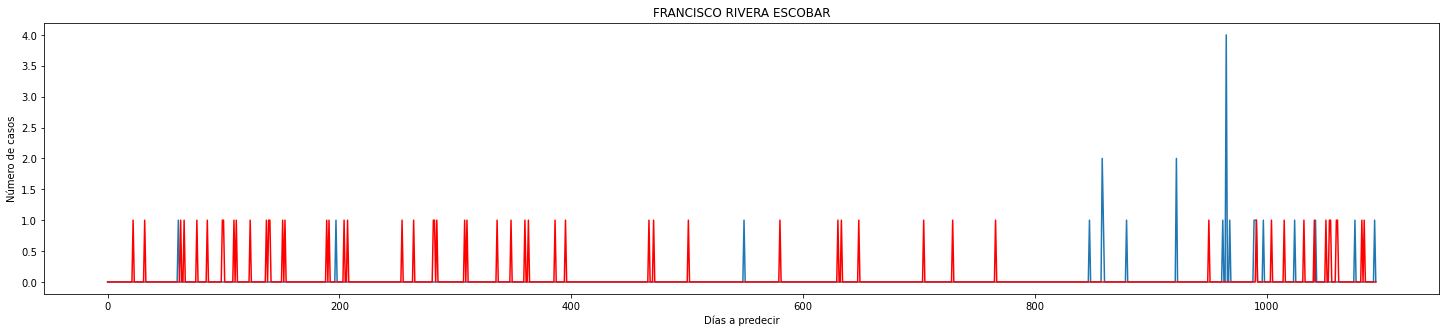

Test RMSE: 0.451


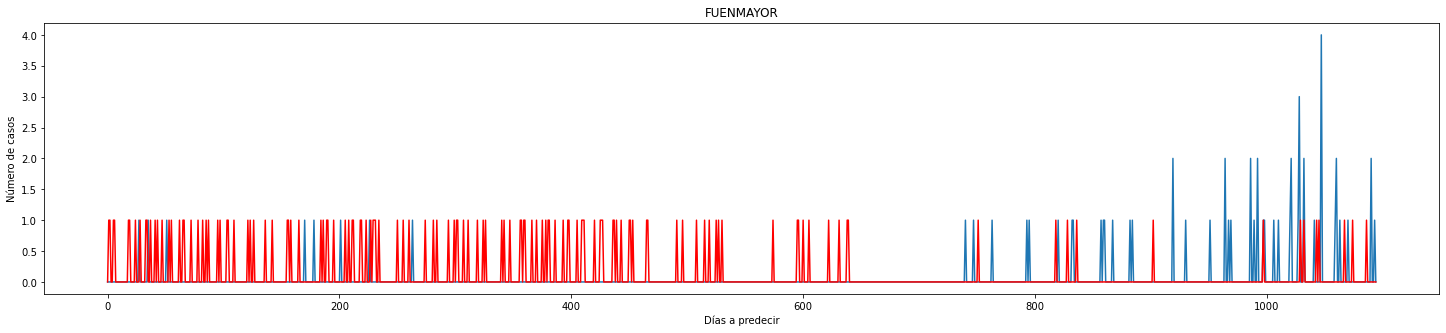

Test RMSE: 0.331


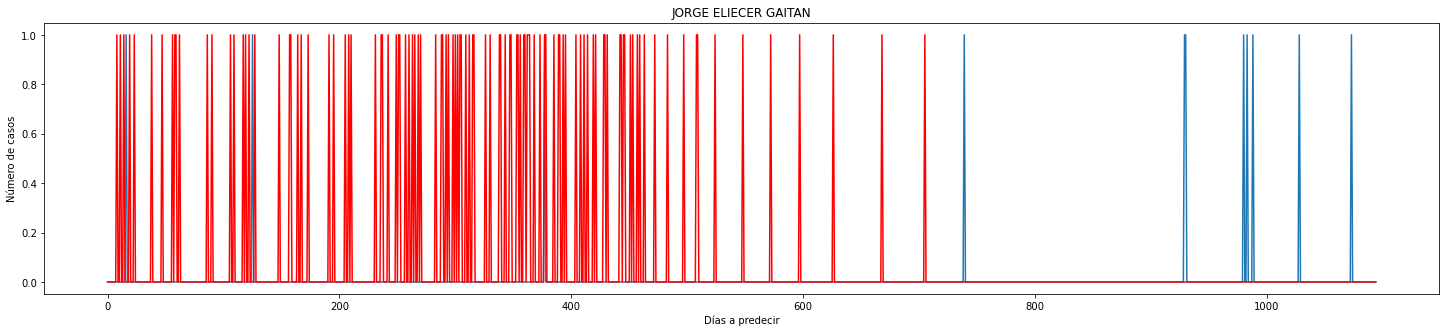

KeyboardInterrupt: 

In [24]:
neighborhoods_df = df2['Barrio'].value_counts().sort_index()

for neighborhood_name in neighborhoods_df.index :
    # Obtención conjunto entrenamiento
    nb_df = buga_data[buga_data.Barrio == neighborhood_name]
    nb_df = pd.DataFrame(nb_df['FecNot'].value_counts().sort_index())
    nb_df.columns = ['Casos']
    nb_df.index.name = 'Fecha'
    df_zeros = assign_zeros(nb_df)
    df_zeros.set_index('Fecha',inplace=True)
    
    # Ejecución del modelo AR
    AR_model2(df_zeros, neighborhood_name)

### Regresión de Poisson

In [35]:
def convert_poisson_variable(model, mu) :
    for value in model.values :
        x = np.arange(scipy.stats.poisson.ppf(value, mu))

In [44]:
np.arange(2,5,3,2)

TypeError: data type not understood

In [47]:
# Graficando Poisson
mu =  3.6 # parametro de forma 
poisson = scipy.stats.poisson(mu) # Distribución
x = np.arange(scipy.stats.poisson.ppf(0.01, mu),
              scipy.stats.poisson.ppf(0.99, mu),
              scipy.stats.poisson.ppf(0.2, mu),
              scipy.stats.poisson.ppf(0.22, mu),
              scipy.stats.poisson.ppf(0.29, mu))

x

TypeError: arange() takes at most 4 arguments (5 given)

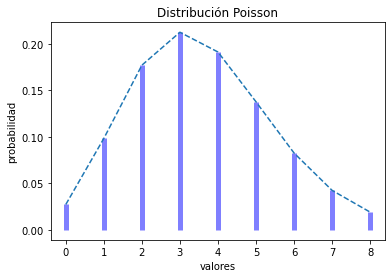

In [26]:
# Graficando Poisson
mu =  3.6 # parametro de forma 
poisson = scipy.stats.poisson(mu) # Distribución
x = np.arange(scipy.stats.poisson.ppf(0.01, mu),
              scipy.stats.poisson.ppf(0.99, mu))
fmp = poisson.pmf(x) # Función de Masa de Probabilidad
plt.plot(x, fmp, '--')
plt.vlines(x, 0, fmp, colors='b', lw=5, alpha=0.5)
plt.title('Distribución Poisson')
plt.ylabel('probabilidad')
plt.xlabel('valores')
plt.show()